## Reddit Toxicity Detection

This dataset contains posts from various subreddits, with each entry providing information on the subreddit name, the text content of the post (body), its controversiality (indicating if it sparked significant discussion), and the score (upvotes minus downvotes) received by the post. It can be used to analyze user engagement and sentiment across different subreddits.

### The Dataset has following attributes
1. **subreddit**: The name of the subreddit where the post was made.
2. **body:** The content or text of the post or comment.
3. **controversiality:** Indicates whether the post is controversial (1 for controversial, 0 for not).
4. **score:** The score (upvotes minus downvotes) received by the post.


In [2]:
import pandas as pd
import numpy as np

In [3]:
## read the dataset
df = pd.read_csv("data/kaggle_RC_2019-05.csv")
df.head()

,subreddit,body,controversiality,score
0,gameofthrones,Your submission has been automatically removed...,0,1
1,aww,"Dont squeeze her with you massive hand, you me...",0,19
2,gaming,It's pretty well known and it was a paid produ...,0,3
3,news,You know we have laws against that currently c...,0,10
4,politics,"Yes, there is a difference between gentle supp...",0,1


In [4]:
## shape of the data
df.shape

(1000000, 4)

In [5]:
## null values
df.isnull().sum()

subreddit           0
body                0
controversiality    0
score               0
dtype: int64

There are no null values

In [6]:
## Different subreddit categorirs
print(df['subreddit'].unique())
print("\nTotal number of distinct subreddit categories: ",df['subreddit'].nunique())

['gameofthrones' 'aww' 'gaming' 'news' 'politics' 'dankmemes'
 'relationship_advice' 'nba' 'worldnews' 'AskReddit' 'AmItheAsshole'
 'SquaredCircle' 'The_Donald' 'leagueoflegends' 'hockey' 'videos'
 'teenagers' 'gonewild' 'movies' 'funny' 'pics' 'marvelstudios' 'memes'
 'soccer' 'freefolk' 'MortalKombat' 'todayilearned' 'apexlegends' 'asoiaf'
 'Market76' 'Animemes' 'FortNiteBR' 'nfl' 'trashy' 'unpopularopinion'
 'ChapoTrapHouse' 'RoastMe' 'Showerthoughts' 'wallstreetbets' 'Pikabu']

Total number of distinct subreddit categories:  40


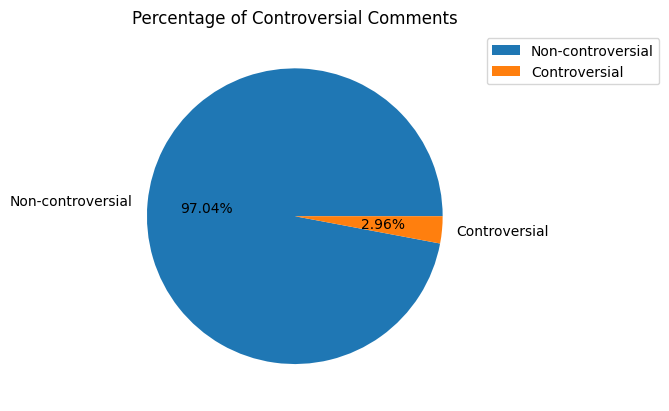

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

size = df['controversiality'].value_counts()

plt.pie(x = size, labels=['Non-controversial','Controversial'], autopct='%1.2f%%')
plt.title("Percentage of Controversial Comments")
plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))
plt.show()


The dataset is imbalanced and therefore needs to be sampled into a balanced dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   subreddit         1000000 non-null  object
 1   body              1000000 non-null  object
 2   controversiality  1000000 non-null  int64 
 3   score             1000000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 30.5+ MB


In [9]:
df.describe()

,controversiality,score
count,1000000.000000,1000000.000000
mean,0.029583,11.510103
std,0.169434,149.671560
min,0.000000,-889.000000
25%,0.000000,1.000000
50%,0.000000,2.000000
75%,0.000000,4.000000
max,1.000000,35619.000000


There are a total of 1 million rows.
1. controversiality is a binary attribute that has either 0 or 1
2. score ranges from -889 to a maximum of 35619 which a total of upvotes and down votes for each commenter

In [10]:
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler

In [11]:
## Taking the sample of data
df_reduced = resample(df,
                      n_samples=50000,
                      stratify=df['controversiality'],
                      random_state=42)

df_reduced = df_reduced.reset_index().drop(columns = ['index'])
df_reduced.head()

,subreddit,body,controversiality,score
0,Showerthoughts,Huh. Then my grandmother was the complete oppo...,0,1
1,MortalKombat,The grinding is my main concern... Consumables...,0,1
2,SquaredCircle,I remember seeing the promo on TV via Star Wor...,0,1
3,Market76,Sounds good! I’ll join you in a bit then,0,1
4,ChapoTrapHouse,Maybe I’m naive but I don’t understand how tha...,0,7


In [12]:
df_reduced['controversiality'].value_counts()

0    48521
1     1479
Name: controversiality, dtype: int64

In [13]:
## balancing the imbalanced dataset

feature = df_reduced['body']
target = df_reduced['controversiality']

oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X, y = oversampler.fit_resample(feature.values.reshape(-1,1), target)

df_balanced = pd.DataFrame({'body': X.flatten(), 'controversiality':y})

In [14]:
df_balanced['controversiality'].value_counts()

0    48521
1    48521
Name: controversiality, dtype: int64

### Preprocessing the data

In [15]:
import re

df_balanced['body'] = df_balanced['body'].apply(lambda x: re.sub('[^a-zA-Z0-9/s]',' ',x))
df_balanced['body'] = df_balanced['body'].apply(lambda x: x.lower())

In [16]:
df_balanced['body']

0        huh  then my grandmother was the complete oppo...
1        the grinding is my main concern    consumables...
2        i remember seeing the promo on tv via star wor...
3                 sounds good  i ll join you in a bit then
4        maybe i m naive but i don t understand how tha...
                               ...                        
97037                      jokes are supposed to be funny 
97038     gt what did the battle prove in the end  that...
97039    i hear isaiah thomas will be available when ky...
97040      breathing on him results in paralysis  so yeah 
97041         it s good you ve taken the high road on this
Name: body, Length: 97042, dtype: object

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
## Tokenizing the text data
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_balanced['body'])

## convert the text to sequences
sequences = tokenizer.texts_to_sequences(df_balanced['body'])

## padding the sequences
max_len = max([len(text) for text in df_balanced['body']])

X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
y = df_balanced['controversiality']

## Split the data into train and test sets

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
print(X_train.shape, y_train.shape)

(77633, 7775) (77633,)


## Model Building

In [19]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=100, input_shape = (X.shape[1],)))
model.add(GRU(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Vipina\FindJ\Resume\GitHub\Reddit_comments\venv\lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
## summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 7775, 100)      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        31,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,033,985 (3.94 MB)

 Trainable params: 1,033,985 (3.94 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
## compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
##  Definig the early stopping
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

In [23]:
## train the model
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=early_stopping)

Epoch 1/100
  1/971 ━━━━━━━━━━━━━━━━━━━━ 2:05:13 8s/step - accuracy: 0.6094 - loss: 0.6904

KeyboardInterrupt: 